# FCNN training

In [1]:
# This is only valid when the package is not installed
import sys
sys.path.append('../../') # two folders up
import DeepINN as dp
import torch

Using default backend: PyTorch
Using Pytorch:  2.0.1+cu117


## Geometry

In [2]:
# A simple 1D geometry
X = dp.spaces.R1('x')
Line = dp.domains.Interval(X, 0, 1)

In [3]:
left_bc = dp.constraint.DirichletBC(geom = Line,
                                      function = lambda X: torch.tensor([0.0]),
                                      sampling_strategy = "grid",
                                      no_points = 1, # you can use more points. there are conditions to deal with stupid conditions. 
                                      filter_fn = lambda x: x[:] == 0.0)
right_bc = dp.constraint.DirichletBC(geom = Line,
                                      function = lambda X: torch.tensor([1.0]),
                                      sampling_strategy = "grid",
                                      no_points = 1, # you can use more points. there are conditions to deal with stupid conditions. 
                                      filter_fn = lambda x: x[:] == 1.0)
interior_points = dp.constraint.PDE(geom = Line,
                                    sampling_strategy= "grid",
                                    no_points = 20)

In [4]:
# dp.utils.scatter(X, interior_points.sampler_object(), dpi = 50)
# dp.utils.scatter(X, left_bc.sampler_object(), dpi = 50)
# dp.utils.scatter(X, right_bc.sampler_object(), dpi = 50)

## PDE

In [5]:
def laplace(X,y):
    """
    1D Laplace equation.
    u__x = 0 
    """
    dy_x = dp.constraint.Jacobian(X, y)(i=0, j=0)
    dy_xx = dp.constraint.Jacobian(X, dy_x)(i = 0, j = 0)

    return dy_xx

In [6]:
domain = dp.domain.Generic(laplace,
                            interior_points,
                            [left_bc, right_bc])

## Network

In [7]:
activation = "tanh"
initialiser = "Xavier normal"
layer_size = [1] + [2] * 1 + [1]

In [8]:
net = dp.nn.FullyConnected(layer_size, activation, initialiser)
model = dp.Model(domain, net)

In [9]:
optimiser = "adam"
lr=0.001
metrics="MSE"

model.compile(optimiser, lr, metrics, device = "cuda")

/home/hell/Desktop/repos/DeepINN/Tutorials/5. FCNN/../../DeepINN/geometry/samplers/grid_samplers.py:78: UserWarning: First iteration did not find any valid grid points, for
                             the given filter.
                             Will try again with n = 10 * self.n_points. Or
                             else use only random points!
  warnings.warn("""First iteration did not find any valid grid points, for
Domain compiled
Network compiled


In [10]:
model.optimiser_function, model.lr, model.metric

(torch.optim.adam.Adam, 0.001, MSELoss())

In [11]:
model.train(iterations = 500)

Iteration: 1 	 BC Loss: 1.1904	 PDE Loss: 0.0000 	 Loss: 1.1904
Iteration: 51 	 BC Loss: 0.8801	 PDE Loss: 0.0000 	 Loss: 0.8801
Iteration: 101 	 BC Loss: 0.6463	 PDE Loss: 0.0000 	 Loss: 0.6463
Iteration: 151 	 BC Loss: 0.4837	 PDE Loss: 0.0000 	 Loss: 0.4837
Iteration: 201 	 BC Loss: 0.3789	 PDE Loss: 0.0000 	 Loss: 0.3789
Iteration: 251 	 BC Loss: 0.3130	 PDE Loss: 0.0000 	 Loss: 0.3130
Iteration: 301 	 BC Loss: 0.2686	 PDE Loss: 0.0000 	 Loss: 0.2686
Iteration: 351 	 BC Loss: 0.2344	 PDE Loss: 0.0000 	 Loss: 0.2344
Iteration: 401 	 BC Loss: 0.2047	 PDE Loss: 0.0000 	 Loss: 0.2047
Iteration: 451 	 BC Loss: 0.1773	 PDE Loss: 0.0000 	 Loss: 0.1773
Iteration: 501 	 BC Loss: 0.1516	 PDE Loss: 0.0000 	 Loss: 0.1516
Training finished
Time taken: 'trainer' in 3.2072 secs


In [12]:
# model.iter = 1
# model.train(iterations = 2000)

In [13]:
model.network

FullyConnected(
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=2, bias=True)
    (1): Linear(in_features=2, out_features=1, bias=True)
  )
)

In [14]:
coordinates_list = dp.utils.tensor2numpy([model.collocation_point_sample, model.boundary_point_sample])
solution_list = dp.utils.tensor2numpy([model.collocation_forward, model.BC_forward])

In [15]:
history = model.training_history

In [16]:
import matplotlib.pyplot as plt

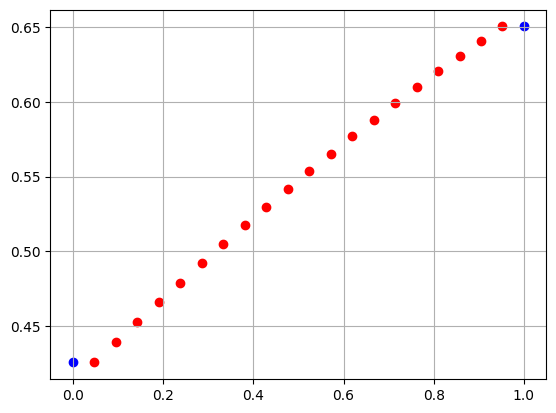

In [17]:
plt.figure(1)
plt.scatter(coordinates_list[0], solution_list[0], label = "collocation points", color = "red")
plt.scatter(coordinates_list[1], solution_list[1], label = "boundary points", color = "blue")
plt.grid('minor')

Text(0, 0.5, 'Loss')

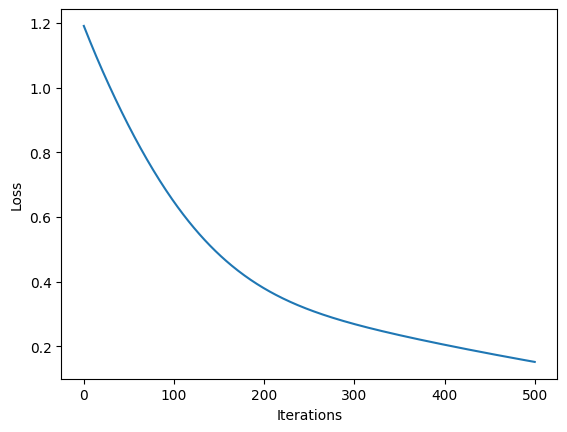

In [18]:
plt.figure(2)
plt.plot(history)
plt.xlabel("Iterations")
plt.ylabel("Loss")